In [1]:
from os.path import join
import joblib
from itertools import compress
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix as cm
from sklearn.decomposition import PCA

# helper functions
from importlib import reload
import model_utils
reload(model_utils)
import data_utils
import viz_utils

plt.rcParams["font.family"] = "Times New Roman"

wd = join("..", "data")
imdir = join(wd, 'images')

In [2]:
gdf = gpd.read_file(join(wd, 'results', 'unseen test set', 'unseen_results.gpkg'))
gdf = gdf[gdf['dist_pw'] > 0]

TP = gdf[gdf['error_type'] == 'TP']
TN = gdf[gdf['error_type'] == 'TN']
FP = gdf[gdf['error_type'] == 'FP']
FN = gdf[gdf['error_type'] == 'FN']

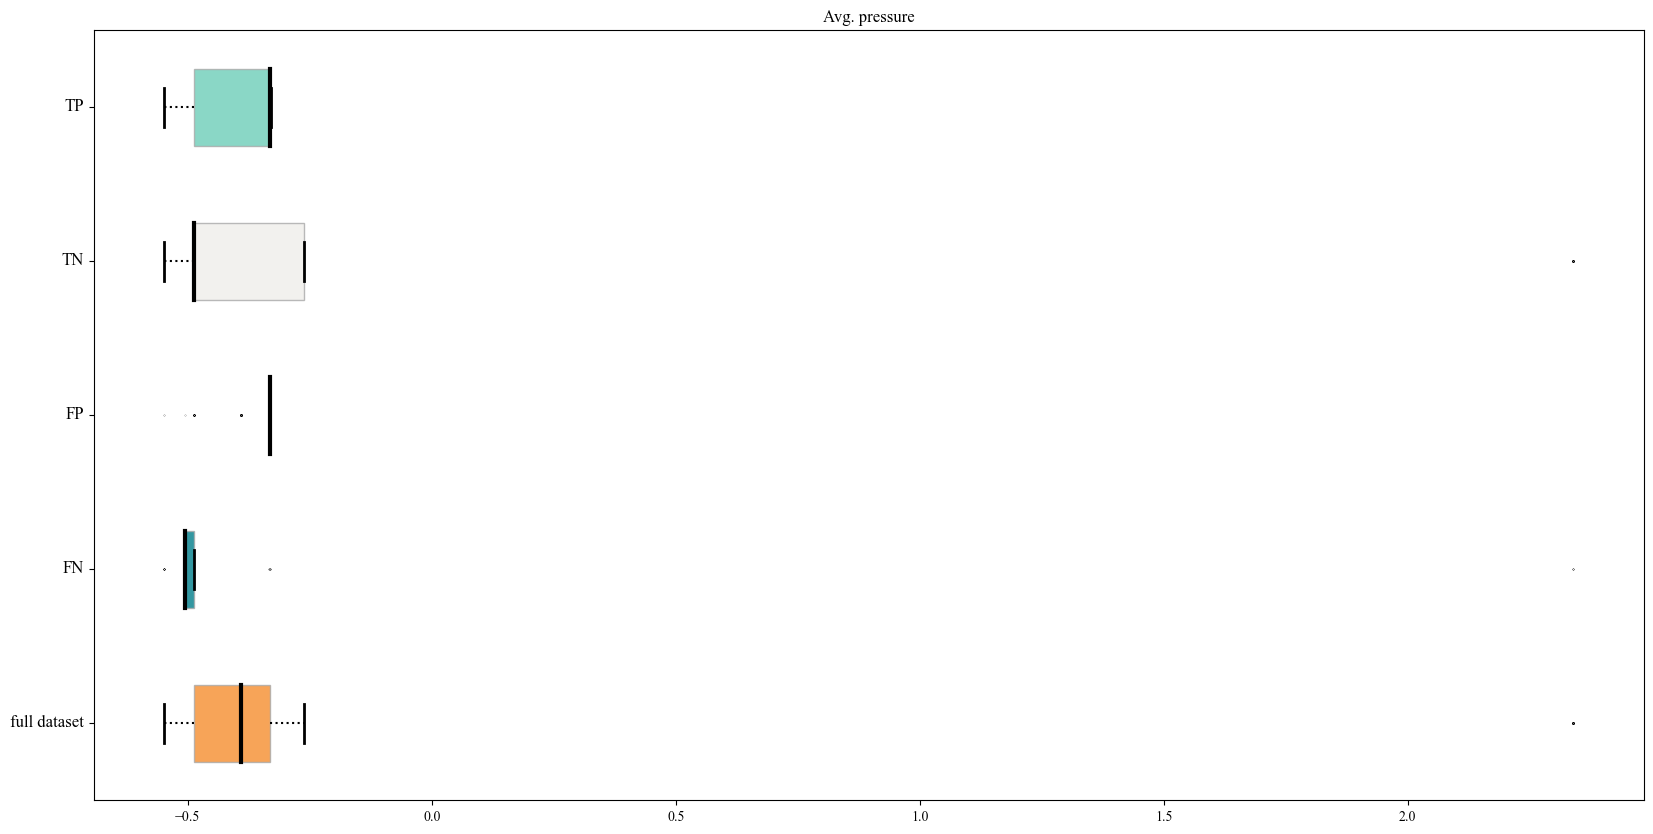

In [6]:
# more viz options to look at: https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
FEATURE = 'pressure_avg'

feat_arrs = []
feat_labs = []
colours = {'full dataset': viz_utils.soge_colours['orange'],
          'TN': viz_utils.soge_colours['beige'],
          'FN': viz_utils.soge_colours['medium turquoise'],
          'FP': viz_utils.soge_colours['yellowish green'],
          'TP': viz_utils.soge_colours['light turquoise']
         }

# first entry is for entire dataset
feat_arrs.append([*gdf[FEATURE]])
feat_labs.append('full dataset')

for error_type in sorted(gdf['error_type'].unique()):
    gdf_error_type = gdf[gdf['error_type'] == error_type]
    feat_arrs.append([*gdf_error_type[FEATURE]])
    feat_labs.append(error_type)
    
colours = [colours[x] for x in feat_labs]
    
# plot
fig, ax = plt.subplots(figsize=(20, 10))

bp = ax.boxplot(feat_arrs, vert=False, patch_artist=True);
ax.set_title(viz_utils.labels[FEATURE].capitalize())
ax.set_yticklabels(feat_labs, rotation=0, fontsize=12, va='center')

for patch, colour in zip(bp['boxes'], colours):
    patch.set_facecolor(colour)
    patch.set_alpha(0.8)
    patch.set_edgecolor('darkgrey')

# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='blue',
              alpha = 0.5,
              markersize=0.1)
    
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")

# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='black',
            linewidth = 2)
    
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)
    
fig.savefig(join(imdir, 'eda', f'error_distributions_{FEATURE}.png'), dpi=400, bbox_inches='tight')

In [ ]:
from viz_utils import soge_colours

# def binfunc(data, binwidth):
# """
# >>>bins=binfunc(TN[feature], binwidth)
# """
#     bins = np.arange(min(data), max(data) + binwidth, binwidth)
#     return bins

# binwidth = 0.15

hist_kwargs = {'alpha': 0.8, 'density': True, 'bins': 20, 'linewidth': 0.3, 'edgecolor': 'grey'}


fig, axs = plt.subplots(1, 2, figsize=(10, 3))
ax = axs[0]

# #  side-by-side
# cols = [soge_colours['beige'], soge_colours['yellowish green'], soge_colours['medium turquoise'], soge_colours['light turquoise']]
# labs = ['TN', 'FP', 'FN', 'TP']
# ax.hist([TN[FEATURE], FP[FEATURE], FN[FEATURE], TP[FEATURE]], color=cols, label=labs, **hist_kwargs)

ax.hist(TN[FEATURE], color=soge_colours['beige'], label='TN', **hist_kwargs)
ax.hist(FP[FEATURE], color=soge_colours['yellowish green'], label='FP', **hist_kwargs)
ax.hist(FN[FEATURE], color=soge_colours['medium turquoise'], label='FN', **hist_kwargs)
ax.hist(TP[FEATURE], color=soge_colours['light turquoise'], label='TP', **hist_kwargs)
ax.legend()

ax.set_title(f"{viz_utils.labels[FEATURE].capitalize()} distribution for four error types")
ax.set_xlabel('Data')
ax.set_ylabel('Frequency')
# ax.set_xlim([-.5, .5])

ax = axs[1]
ax.hist(gdf[FEATURE], color=soge_colours['orange'], label='All', **hist_kwargs)
ax.set_title(f"{viz_utils.labels[FEATURE].capitalize()} distribution overall")
ax.set_xlabel('Data')
ax.set_ylabel('Frequency')

plt.show()

fig.savefig(join(wd, 'results', 'unseen test set', f'distribution_{FEATURE}.png'), dpi=400, bbox_inches='tight')

In [ ]:
feature = 'soiltemp2_anom'
hist_kwargs = {'alpha': 0.8, 'density': True, 'bins': 20, 'linewidth': 0.3, 'edgecolor': 'grey'} # 'orientation': 'horizontal'}
               

cols = [*viz_utils.soge_colours.values()]
cols.remove('#002147')

fig, ax = plt.subplots()
for event, colour in zip(gdf['event'].unique(), cols):
    gdf_event = gdf[gdf['event'] == event]
    ax.hist(gdf_event[feature], color=colour, label=event, **hist_kwargs)
    ax.legend(loc='upper right')
    
ax.set_title(f"{viz_utils.labels[feature]} distribution for unseen tiles")
ax.set_xlabel('Data')
ax.set_ylabel('Frequency')
ax.set_xlim([-1, 1])
ax.set_ylim([0, 20])

plt.show()

fig.savefig(join(wd, 'results', 'unseen test set', f'eventdists_{feature}.png'), dpi=400, bbox_inches='tight')

# Visualise a tree

In [212]:
rf = joblib.load(join(wd, 'results', 'unseen test set', 'random_forest_reduceddepth.joblib'))
features = pd.read_csv(join(wd, 'results', 'unseen test set', 'random_forest_features.csv'))
features = features.loc[:, '0'].to_list()

print(f"Model has {len(rf.estimators_)} trees.")  

Model has 1000 trees.


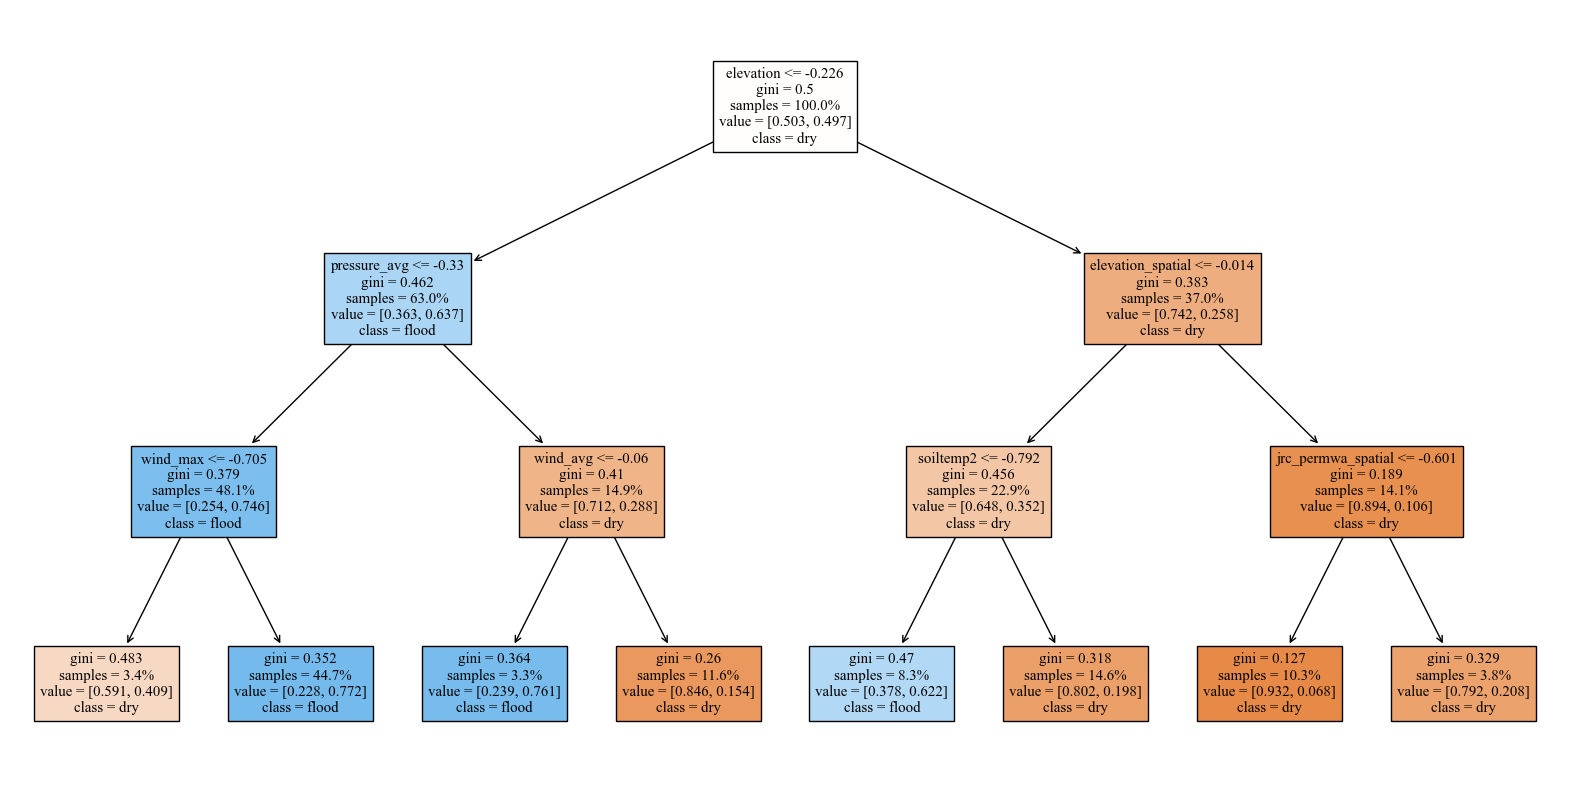

In [219]:
from sklearn import tree

TREE_NUM = 500
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(rf.estimators_[TREE_NUM], feature_names=features, class_names=['dry', 'flood'],
               proportion=True, filled=True, ax=ax);
fig.savefig(join(wd, 'results', f'random_forest_tree_{TREE_NUM}.png'), dpi=400, bbox_inches='tight')

# Flood types

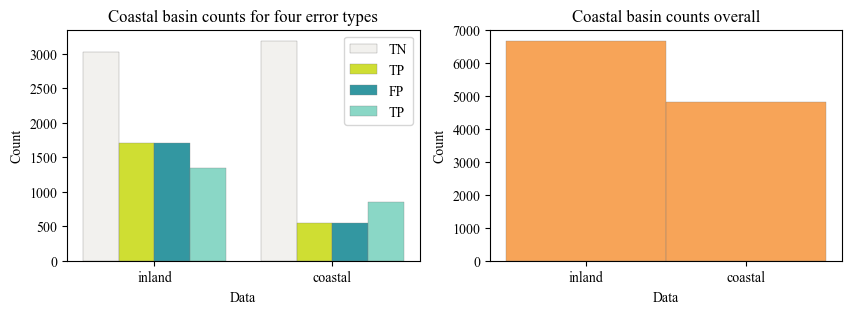

# Dendograms

In [109]:
features = ['elevation', 'elevation_spatial', 'elevation_to_pw', 'jrc_permwa',
            'jrc_permwa_spatial', 'slope_pw', 'dist_pw', 'precip', 'wind_avg',
            'pressure_avg', 'wind_max', 'pressure_min', 'mangrove',
            'mangrove_spatial', 'mangrove_to_pw', 'evi', 'evi_anom', 'evi_spatial',
            'evi_to_pw', 'built_up', 'bare_soil', 'soilcarbon',
            'soilcarbon_spatial', 'soilcarbon_to_pw', 'soiltemp2', 'soiltemp2_anom',
            'aqueduct', 'deltares']

# 'floodfrac', 'flood_pred', 'error_type', 'exclusion_mask'

In [110]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [111]:
# model.children_

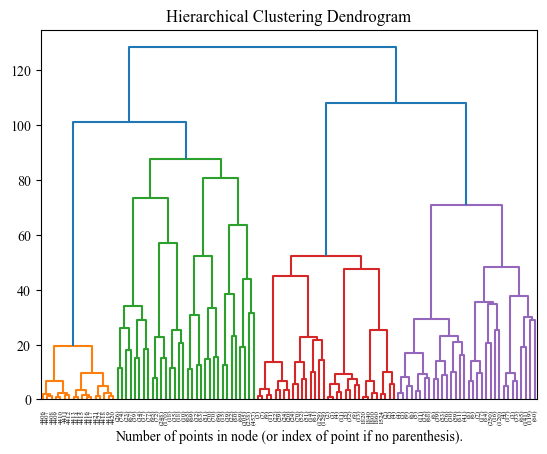

In [112]:
# setting distance_threshold=0 ensures we compute the full tree.


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(gdf[features])

fig, ax = plt.subplots()

ax.set_title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=6, ax=ax)
ax.set_xlabel("Number of points in node (or index of point if no parenthesis).");


In [113]:
def get_label(x, gdf, feature):
    try:
        x = int(x.get_text())
        return gdf.loc[x][feature]
    except Exception:
        return x
    
    
get_label(labels[0], gdf, 'error_type')

'TN'

In [114]:
model = AgglomerativeClustering(distance_threshold=None, n_clusters=4)
model.fit(gdf[features])
model.n_clusters_

4

In [90]:
gdf['aggClust'] = model.labels_

<AxesSubplot: >

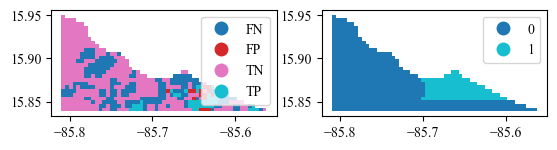

In [103]:
event = 'iota_loweraguanbasin_0'

fig, ax = plt.subplots(1, 2)

gdf[gdf['event'] == event].plot('error_type', ax=ax[0],  categorical=True, legend=True)
gdf[gdf['event'] == event].plot('aggClust', ax=ax[1],  categorical=True, legend=True)